In [1]:
%%writefile ./run_xshift.sh
#!/bin/bash

#SBATCH -n 20                            #Number of cores
#SBATCH -N 1                            #Run on 1 node
#SBATCH --mem=12000                       #Memory per cpu in MB (see also --mem)

#SBATCH -t 10:00:00                     #Runtime in minutes
#SBATCH -p serial_requeue               #Partition to submit to

cd ${1}
cp ../../${2} .
mv ${2} fcsFileList.txt
cp ../../importConfig.txt .
module load centos6/0.0.1-fasrc01
module load java/1.8.0_45-fasrc01
java -Xmx10G -cp "../../VorteX.jar" standalone.Xshift ${3}

Overwriting ./run_xshift.sh


In [1]:
%%writefile ./run_xshift_auto.sh
#!/bin/bash

#SBATCH -n 32                            #Number of cores
#SBATCH -N 1                            #Run on 1 node
#SBATCH --mem=12000                       #Memory per cpu in MB (see also --mem)

#SBATCH -t 15:00:00                     #Runtime in minutes
#SBATCH -p serial_requeue               #Partition to submit to

cd ${1}
cp ../../${2} .
mv ${2} fcsFileList.txt
cp ../../importConfig.txt .
echo ${1}
module load centos6/0.0.1-fasrc01
module load java/1.8.0_45-fasrc01
java -Xmx10G -cp "../../VorteX.jar" standalone.Xshift auto

Overwriting ./run_xshift_auto.sh


In [1]:
!sbatch run_xshift.sh BALBc-3/135 fcsFileList_BALBc-3.txt 135

Submitted batch job 46087869


In [7]:
import pandas as pd
import fcsparser
import fcswrite

# combine FCS files into one 
combined_fcs = []
for sample in samples:
    _, data = fcsparser.parse(fcs_folder + sample + '.fcs')
    combined_fcs.append(data)
combined_fcs = pd.concat(combined_fcs)
fcswrite.write_fcs(filename=fcs_folder+'combined.fcs', 
                   chn_names=list(combined_fcs.columns), 
                   data=combined_fcs.values)

/n/home05/aewhatley/anaconda3/lib/python3.6/site-packages/fcsparser/api.py:332: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
  warnings.warn(msg)


In [3]:
import os

samples = ['BALBc-1', 'BALBc-2', 'BALBc-3', 'MRL-4', 'MRL-5', 'MRL-6', 'MRL-7', 'MRL-8', 'MRL-9', 'combined']
#neighbors = range(5, 100+1)
neighbors = range(105, 500+1, 5)
fcs_folder = '/n/regal/nowak_lab/aewhatley/FCS_Files/'
#paths = [fcs_folder + filename for filename in os.listdir(fcs_folder)]
for sample in samples:
    paths = [fcs_folder + sample + '.fcs']
    f = open('fcsFileList_{}.txt'.format(sample), 'w')
    f.write('\n'.join(paths))
    f.close()

In [3]:
import subprocess
import os

for sample_type in samples:
    if not os.path.isdir(sample_type):
        os.mkdir(sample_type)
    for i in neighbors:
        if not os.path.isdir(sample_type + '/' + str(i)):
            os.makedirs(sample_type + '/' + str(i))
        if not os.path.isdir(sample_type + '/' + str(i) + '/out'):
            subprocess.Popen('sbatch run_xshift.sh {} {} {}'.format(sample_type + '/' + str(i),
                                                                    'fcsFileList_{}.txt'.format(sample_type),
                                                                    i), shell=True)

In [5]:
import subprocess
import os

# get elbow point for each sample 
for sample_type in samples:
    if not os.path.isdir(sample_type):
        os.mkdir(sample_type)
    if not os.path.isdir(sample_type + '/auto'):
        os.makedirs(sample_type + '/auto')
    if not os.path.isdir(sample_type + '/auto/out'):
        subprocess.Popen('sbatch run_xshift_auto.sh {} {}'.format(sample_type + '/auto',
                                                                'fcsFileList_{}.txt'.format(sample_type)), 
                         shell=True)

In [5]:
import pandas as pd
import fcsparser 

# combine all generated fcs files together 
def concat_files(filename='BALBc-1.fcs'):
    concat_data = []
    for i in neighbors:
        file_path = 'BALBc-1/' + str(i) + '/out/' + filename
        if os.path.isfile(file_path):
            _, df = fcsparser.parse(file_path)
            df['Neighbors'] = i
            concat_data.append(df)
    concat_data = pd.concat(concat_data)
    concat_data.to_csv('concat.csv', index=False)
    
concat_files()

/n/home05/aewhatley/anaconda3/lib/python3.6/site-packages/fcsparser/api.py:332: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
  warnings.warn(msg)


In [3]:
import fcsparser

file = '/n/regal/nowak_lab/aewhatley/FCS_Files/BALBc-1.fcs'
_, data = fcsparser.parse(file)
print(data.columns[0:29])

Index(['CD45', 'Ly6C', 'TCR', 'Ly6G', 'CD19', 'CD169', 'CD106', 'CD3', 'CD16',
       'CD8a', 'CD90', 'F4', 'CD11c', 'Ter119', 'CD11b', 'IgD', 'CD27', 'CD5',
       'CD79b', 'CD71', 'CD31', 'CD4', 'IgM', 'B220', 'ERTR7', 'CD35', 'CD21',
       'CD44', 'NKp46'],
      dtype='object')


/n/home05/aewhatley/anaconda3/lib/python3.6/site-packages/fcsparser/api.py:332: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
  warnings.warn(msg)


In [4]:
data.head()

,CD45,Ly6C,TCR,Ly6G,CD19,CD169,CD106,CD3,CD16,CD8a,...,Z.Z,size.size,MHCII,blank_Cy3_cyc15,blank_Cy5_cyc15,blank_Cy3_cyc16,blank_Cy5_cyc16,region,sampleid,"cluster X-shift (Gradient assignment), K=60"
0,7513.909180,-9.574835,3305.558594,-6.746789,1245.058594,-286.788666,3036.938477,783.750916,3627.429932,848.653809,...,9.0,15093.0,3196.876221,2159.819092,858.781189,1317.001465,1390.218506,1.0,1000.0,9619.0
1,-56.765057,-53.891575,76.769524,-0.275126,-35.436699,119.786873,-854.304810,251.204300,-579.770325,231.985855,...,9.0,9828.0,-54.244442,-139.026733,99.173172,205.848129,403.930115,1.0,1000.0,9615.0
2,2779.814697,275.005005,550.123596,224.658813,794.820862,558.794495,5265.109375,333.537537,3043.125488,1328.199097,...,9.0,6836.0,954.858582,1263.183472,884.518860,1288.393311,1583.370728,1.0,1000.0,9613.0
3,2385.769287,-84.199524,441.045197,-28.191748,1145.059448,-585.042664,445.197876,-730.253906,194.302200,530.927307,...,9.0,6193.0,3299.813965,1704.029785,563.394043,1578.766846,513.424866,1.0,1000.0,9640.0
4,747.012817,110.129936,347.603699,103.125900,216.466614,49.535763,828.020813,-66.413368,538.524170,413.145752,...,7.0,7120.0,864.733765,1115.607056,579.967407,1081.695557,929.925781,1.0,1000.0,9613.0


/n/home05/aewhatley/anaconda3/lib/python3.6/site-packages/fcsparser/api.py:332: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
  warnings.warn(msg)


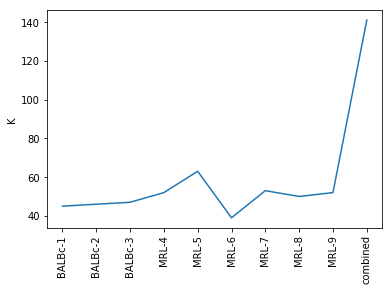

In [2]:
import fcsparser
import numpy as np
import matplotlib.pyplot as plt 

samples = ['BALBc-1', 'BALBc-2', 'BALBc-3', 'MRL-4', 'MRL-5', 'MRL-6', 'MRL-7', 'MRL-8', 'MRL-9', 'combined']
elbows = []
for sample in samples:
    _, data = fcsparser.parse(sample + '/auto/out/' + sample + '.fcs')
    elbow = len(data['cluster_id'].unique())
    elbows.append(elbow)

plt.plot(np.arange(len(samples)), elbows)
plt.xticks(np.arange(len(samples)), samples, rotation='vertical')
plt.ylabel('K')
plt.show()

In [5]:
from combat import combat 
from patsy import dmatrix 
import fcsparser
import fcswrite
import pandas as pd 

supplementary_data = pd.read_csv('../Suppl.Table2.CODEX_paper_MRLdatasetexpression.csv')
supplementary_data = supplementary_data[['X.X', 'Y.Y', 'Z.Z', 'sample_Xtile_Ytile', 
                                         'CD45', 'Imaging phenotype cluster ID']]
supplementary_data.rename(columns={'X.X': 'X', 'Y.Y': 'Y', 'Z.Z': 'Z'}, inplace=True)
supplementary_data['CD45_int'] = supplementary_data['CD45'].astype(int)
supplementary_annotations = pd.read_excel('../Suppl.Table2.cluster annotations and cell counts.xlsx')
dirt = supplementary_annotations.loc[supplementary_annotations['Imaging phenotype (cell type)'] == 'dirt', 'X-shift cluster ID']
# remove dirt from supplementary data 
supplementary_data = supplementary_data[~supplementary_data['Imaging phenotype cluster ID'].isin(dirt)]

def convert_coordinates(df, tile_length=1342, tile_width=1006):
    df['tile_x'] = df['sample_Xtile_Ytile'].apply(lambda x: int(x.split('_')[1][2])) - 1
    df['tile_y'] = df['sample_Xtile_Ytile'].apply(lambda x: int(x.split('_')[2][2])) - 1
    df['X'] = tile_length * df['tile_x'] + df['X']
    df['Y'] = tile_width * df['tile_y'] + df['Y']
    
    return df

def process_fcs(df):
    df.rename(columns={'F4': 'F480', 'CD16': 'CD1632', 'CD21': 'CD2135', 
                       'X.X': 'X', 'Y.Y': 'Y', 'Z.Z': 'Z'}, inplace=True)
    df['CD45_int'] = df['CD45'].astype(int)
    df = pd.merge(df, supplementary_data, on=['X', 'Y', 'Z', 'CD45_int'])
    df = convert_coordinates(df)
    df['sample'] = df['sample_Xtile_Ytile'].apply(lambda x: x.split('_')[0])
    df.drop(['CD45_int'], axis=1, inplace=True)
    
    return df

fcs_folder = '/n/regal/nowak_lab/aewhatley/FCS_Files/'
_, combined_data = fcsparser.parse(fcs_folder + 'combined.fcs')
combined_data = process_fcs(combined_data)
feature_cols = combined_data.columns[:29]
samples = combined_data['sample'].values
intensities = combined_data[feature_cols]
mod = dmatrix('+'.join(feature_cols) + '-1', intensities, return_type="dataframe")
print(mod)
print(mod.shape)
batch_removal = combat(intensities, samples, mod)

print(batch_removal)

/n/home05/aewhatley/anaconda3/lib/python3.6/site-packages/fcsparser/api.py:189: UserWarning: There appears to be some information in the ANALYSIS segment of file /n/regal/nowak_lab/aewhatley/FCS_Files/combined.fcs. However, it might not be read correctly.
  u'{0}. However, it might not be read correctly.'.format(self.path))


              CD45_x         Ly6C          TCR          Ly6G         CD19  \
0        7513.909180    -9.574835  3305.558594     -6.746789  1245.058594   
1         -56.765057   -53.891575    76.769524     -0.275126   -35.436699   
2        2779.814697   275.005005   550.123596    224.658813   794.820862   
3        2385.769287   -84.199524   441.045197    -28.191748  1145.059448   
4         747.012817   110.129936   347.603699    103.125900   216.466614   
5        6462.291992  -153.621338  -615.573792   -158.003967  1946.585938   
6        4609.129883   210.552170   817.662415    319.663574  1693.730713   
7        7130.077148  -760.716858    20.096004   -693.956421   824.959778   
8        2575.713379    -7.136971  -141.847275      2.740026   697.089600   
9        2968.146729   -20.077360   763.639038    -19.316156  1668.955200   
10       2860.189209  1609.882690  -194.319321  10578.153320  -231.220749   
11       4616.200684   109.183311    56.608055     16.112137  1381.899780   

found 9 batches
found 0 numerical covariates...
found 29 categorical variables:	CD45_x, Ly6C, TCR, Ly6G, CD19, CD169, CD106, CD3, CD1632, CD8a, CD90, F480, CD11c, Ter119, CD11b, IgD, CD27, CD5, CD79b, CD71, CD31, CD4, IgM, B220, ERTR7, CD35, CD2135, CD44, NKp46
Standardizing Data across genes.


ValueError: shapes (38,707480) and (29,707480) not aligned: 707480 (dim 1) != 29 (dim 0)